In [ ]:
#Problem 1 

In [4]:
import numpy as np
import pandas as pd
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#a

In [5]:
data = pd.read_csv("incomes.txt",names=['Income'])
data.describe()

,Income
count,200.000000
mean,85276.823606
std,18037.692869
min,47628.560636
25%,71850.308175
50%,83864.444560
75%,96059.995074
max,139079.351549


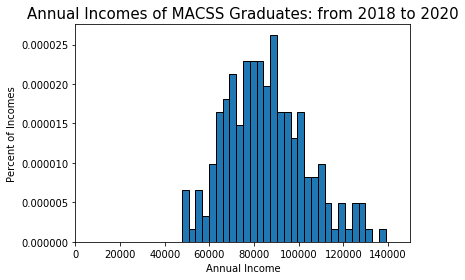

In [6]:
num_bins = 30
plt.hist(data['Income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates: from 2018 to 2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([1, 150000])
plt.show()

In [ ]:
#b

In [8]:
#Define function that generates values of a lognormal pdf
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma,scale=np.exp(mu)))
            
    pdf_vals    = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [9]:
#This function computes the two data moments for GMM (mean(data), S.D.(data)).
def data_moments(xvals):

    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

In [10]:
#This function computes the two model moments for GMM (mean(model data), S.D.(model data)).
def model_moments(mu, sigma, cut_lb, cut_ub):
   
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, np.sqrt(var_model)

In [11]:
#This function computes the vector of moment errors for GMM.
def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):

    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [12]:
def criterion(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [16]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2) #Identity matrix
gmm_args = (data['Income'], 0.0, 150000.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mean_data, std_data = data_moments(data['Income'])
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 150000.0)
err1 = err_vec(data['Income'], mu_GMM1, sig_GMM1, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard Deviation of points =', std_data)
print('Mean of model =', mean_model, ', Standard Deviation =', std_model)
print('Error vector=', err1)
print('GMM criterion function:',results.fun)

mu_GMM1= 11.33353348254704  sig_GMM1= 0.21386191435240418
Mean of points = 85276.82360625808 , Standard Deviation of points = 18037.692869371564
Mean of model = 85276.82405894266 , Standard Deviation = 18037.692424757075
Error vector= [ 5.30841270e-09 -2.46491883e-08]
GMM criterion function: [[6.35761731e-16]]


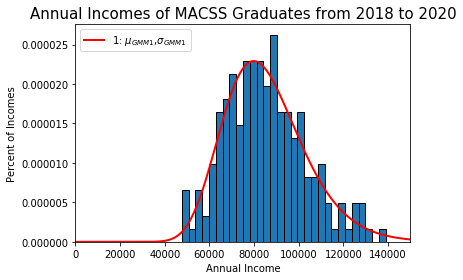

In [18]:
# Plot the histogram of the data
num_bins = 30
plt.hist(data['Income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates from 2018 to 2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([1, 150000])

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#c

In [19]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - std_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - std_model) / std_model
    
    return Err_mat

In [21]:
Err_mat =get_Err_mat2(data['Income'], mu_GMM1, sig_GMM1, 0.0, 150000.0, False)
VCV2 = (1 / data['Income'].shape[0]) * (Err_mat @ Err_mat.T)
print("VCV2:","\n",VCV2)
W_hat2 = lin.inv(VCV2)
print("W_hat2:","\n",W_hat2)

VCV2: 
 [[4.45167060e-02 1.67963797e+03]
 [1.67963797e+03 9.49413425e+08]]
W_hat2: 
 [[ 2.40701669e+01 -4.25833101e-05]
 [-4.25833101e-05  1.12861743e-09]]


In [22]:
gmm_args = (data['Income'], 0.0, 150000.0, W_hat2)
params_init = np.array([mu_GMM1, sig_GMM1])
results2 = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 0.0, 150000.0)
err2 = err_vec(data['Income'], mu_GMM2, sig_GMM2, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard Deviation of points =', std_data)
print('Mean of model =', mean_model2, ', Standard Deviation of model =', std_model2)
print('Error vector=', err2)
print('GMM criterion function:',results2.fun)

mu_GMM2= 11.333533472755567  sig_GMM2= 0.2138619137414828
Mean of points = 85276.82360625808 , Standard Deviation of points = 18037.692869371564
Mean of model = 85276.82324668273 , Standard Deviation of model = 18037.6922484816
Error vector= [-4.21656596e-09 -3.44218060e-08]
GMM criterion function: [[4.27941452e-16]]


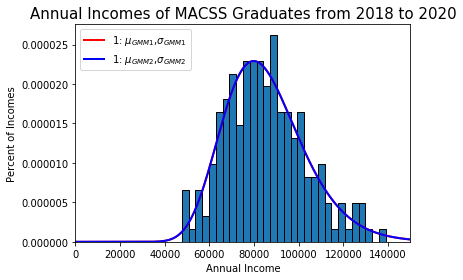

In [23]:
num_bins = 30
plt.hist(data['Income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates from 2018 to 2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([1, 150000])
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, 0.0, 150000),
         linewidth=2, color='b', label='1: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#d

In [27]:
def data_moments3(xvals):
    dat_1 = xvals[xvals <75000].shape[0] / xvals.shape[0]
    dat_2 = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    dat_3 = xvals[xvals >= 100000].shape[0] / xvals.shape[0]
    return dat_1, dat_2, dat_3

In [28]:
def model_moments3(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mod_1, err_1) = intgr.quad(xfx, 0.0, 75000)
    (mod_2, err_2) = intgr.quad(xfx, 75000, 100000)
    (mod_3, err_3) = intgr.quad(xfx, 100000, 150000)
    return mod_1, mod_2, mod_3

In [29]:
def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    dat_1, dat_2, dat_3 = data_moments3(xvals)
    moms_data = np.array([[dat_1], [dat_2], [dat_3]])
    mod_1, mod_2, mod_3 = model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mod_1], [mod_2], [mod_3]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [30]:
def criterion3(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [31]:
W_hat1_3 = np.eye(3)
gmm_args = (data['Income'], 0.0, 150000.0, W_hat1_3)

results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)
err3 = err_vec3(data['Income'], mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False).reshape(3,)

dat_1, dat_2, dat_3 = data_moments3(data['Income'])
pert1, pert2, pert3 = model_moments3(mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0)

print('Error vector=', err3)
print('GMM criterion function:',results_3.fun)
mm = pd.DataFrame({'Data Moments':[dat_1, dat_2, dat_3],
                'Model Momets':[pert1, pert2, pert3]},
                index=['Percent <75000','Percent 75000~100000','Percent >=100000'])
mm

mu_GMM1_3= 11.3367051627647  sig_GMM1_3= 0.21151353494382988
Error vector= [ 1.61522382e-07 -7.19526214e-08 -6.24020183e-08]
GMM criterion function: [[3.51606715e-14]]


,Data Moments,Model Momets
Percent <75000,0.3,0.3
Percent 75000~100000,0.5,0.5
Percent >=100000,0.2,0.2


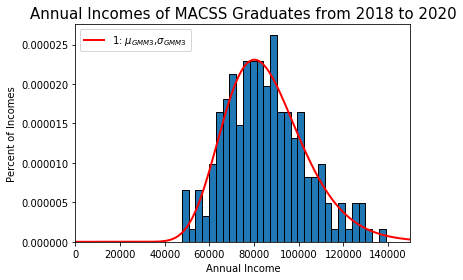

In [33]:
num_bins = 30
plt.hist(data['Income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates from 2018 to 2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([1, 150000])
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')
plt.show()

In [34]:
#e

In [37]:
def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mod_1, mod_2, mod_3 = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - mod_1
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - mod_2
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = pts_in_grp3 - mod_3

    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - mod_1) / mod_1
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - mod_2) / mod_2
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = (pts_in_grp3 - mod_3) / mod_3
    
    return Err_mat

In [38]:
Err_mat3w = get_Err_mat3(data['Income'], mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False)
VCV2_3w = (1 / data['Income'].shape[0]) * (Err_mat3w @ Err_mat3w.T)
print("VCV2_3:","\n",VCV2_3w)
W_hat2_3 = lin.pinv(VCV2_3w)
print("W_hat2_3","\n",W_hat2_3)

VCV2_3: 
 [[ 2.33333258 -0.99999991 -0.9999999 ]
 [-0.99999991  1.00000014 -1.00000013]
 [-0.9999999  -1.00000013  4.0000005 ]]
W_hat2_3 
 [[ 0.25761775 -0.14958453 -0.01246539]
 [-0.14958453  0.11911361 -0.07340718]
 [-0.01246539 -0.07340718  0.20221604]]


In [39]:
gmm_args = (data['Income'], 0.0, 150000.0, W_hat2_3)
results_4 = opt.minimize(criterion3, params_init, args=(gmm_args),method='L-BFGS-B')
mu_GMM1_3w, sig_GMM1_3w = results_4.x
print('mu_GMM1_3w=', mu_GMM1_3w, ' sig_GMM1_3w=', sig_GMM1_3w)
err3w = err_vec3(data['Income'], mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000.0, False).reshape(3,)

pert1, pert2, pert3 = model_moments3(mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000.0)

print('Error vector=', err3w)
print('GMM criterion function:',results_4.fun)
mm = pd.DataFrame({'Data Moments':[dat_1, dat_2, dat_3],
                'Model Momets':[pert1, pert2, pert3]},
                index=['Percent <75000','Percent 75000~100000','Percent >=100000'])
mm

mu_GMM1_3w= 11.33353348254704  sig_GMM1_3w= 0.21386191435240418
Error vector= [ 0.02420924 -0.01108994 -0.00858902]
GMM criterion function: [[0.00025207]]


,Data Moments,Model Momets
Percent <75000,0.3,0.307263
Percent 75000~100000,0.5,0.494455
Percent >=100000,0.2,0.198282


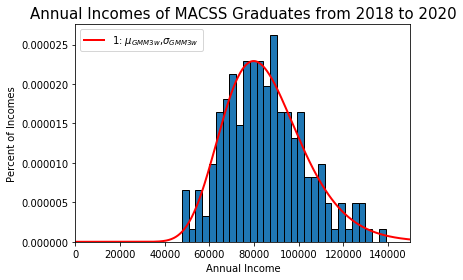

In [40]:
num_bins = 30
plt.hist(data['Income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates from 2018 to 2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([1, 150000])
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM3w}$,$\sigma_{GMM3w}$')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#f

In [41]:
mu = [mu_GMM1, mu_GMM2, mu_GMM1_3, mu_GMM1_3w]
sig = [sig_GMM1, sig_GMM2, sig_GMM1_3, sig_GMM1_3w]
GMMV = [results.fun, results2.fun, results_3.fun, results_4.fun]

In [43]:
pd.DataFrame({"mu":mu,"sigma":sig,"GMM Fn Value":GMMV}
            ,index=['2 moments Identity Matrix','2 moments Weighted Matrix',
                   '3 moments Identity Matrix','3 moments Weighted Matrix']).astype(float)

,mu,sigma,GMM Fn Value
2 moments Identity Matrix,11.333533,0.213862,6.357617e-16
2 moments Weighted Matrix,11.333533,0.213862,4.279415e-16
3 moments Identity Matrix,11.336705,0.211514,3.516067e-14
3 moments Weighted Matrix,11.333533,0.213862,2.520739e-04


(c) fits the data best because it has the lowest minimized GMM function value with 2 moments weighted matrix. 

In [ ]:
#Problem 2

In [44]:
data = pd.read_csv("sick.txt").astype('float64')
data.describe()

,sick,age,children,avgtemp_winter
count,200.000000,200.000000,200.000000,200.000000
mean,1.008600,40.683850,1.674950,44.041250
std,0.504222,11.268686,0.969761,11.101977
min,0.040000,12.810000,0.000000,16.500000
25%,0.650000,33.967500,0.970000,36.112500
50%,0.960000,41.015000,1.560000,43.300000
75%,1.322500,47.750000,2.322500,52.172500
max,2.800000,74.890000,4.960000,68.600000


In [45]:
def err_vec(data,b0,b1,b2,b3):
    yhat = b0 + b1 * data['age'] + b2 * data['children'] + b3 * data['avgtemp_winter']
    y = data['sick']
    err_vec = yhat - y
    
    return err_vec

In [46]:
def criterion(params, *args):
    b0,b1,b2,b3 = params
    data, W = args
    err = err_vec(data,b0,b1,b2,b3)
    crit_val = err.T @ W @ err
    
    return crit_val

In [47]:
b0, b1, b2, b3 = 1, 0, 0, 0
params_init = np.array([b0, b1, b2, b3])
W_hat = np.eye(data.shape[0])
gmm_args = (data, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14, method='L-BFGS-B')
b0, b1, b2, b3 = results.x

In [49]:
print("Estimate value of b0:",b0)
print("Estimate value of b1:",b1)
print("Estimate value of b2:",b2)
print("Estimate value of b3:",b3)
print('GMM criterion function value:',results.fun)

Estimate value of b0: 0.2516448636612042
Estimate value of b1: 0.012933470965564249
Estimate value of b2: 0.40050098470289774
Estimate value of b3: -0.009991709711286762
GMM criterion function value: 0.0018212898060782808
